IMPORT LIBRARIES

In [3]:
import pandas as pd
import sqlite3


LOAD DATA FILES


In [5]:
orders = pd.read_csv("/content/orders.csv")
orders.head()

,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


In [7]:
users = pd.read_json("/content/users.json")
users.head()

,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


In [9]:
conn = sqlite3.connect("restaurants.db")

with open("/content/restaurants.sql", "r") as f:
    sql_script = f.read()

conn.executescript(sql_script)

In [11]:
restaurants = pd.read_sql("SELECT * FROM restaurants", conn)
restaurants.head()


,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


MERGE DATASETS (LEFT JOINS)

In [12]:
merged = orders.merge(users, on="user_id", how="left")


In [13]:
final_df = merged.merge(restaurants, on="restaurant_id", how="left")
final_df.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


SAVE FINAL DATASET

In [14]:
final_df.to_csv("final_food_delivery_dataset.csv", index=False)


In [15]:
from google.colab import files
files.download("final_food_delivery_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

City with highest total revenue from Gold members

In [16]:
# City with highest total revenue from Gold members
gold_city_revenue = (
    final_df[final_df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .sum()
    .sort_values(ascending=False)
)
gold_city_revenue


,total_amount
city,
Chennai,1080909.79
Pune,1003012.32
Bangalore,994702.59
Hyderabad,896740.19


In [17]:
# Cuisine with highest average order value
final_df.groupby("cuisine")["total_amount"] \
        .mean() \
        .sort_values(ascending=False)


,total_amount
cuisine,
Mexican,808.021344
Italian,799.448578
Indian,798.466011
Chinese,798.389020


In [19]:
# Distinct users with total spending > ₹1000
user_spending = final_df.groupby("user_id")["total_amount"].sum()
user_spending[user_spending > 1000].count()


np.int64(2544)

In [20]:
# Rating range with highest total revenue
bins = [3.0, 3.5, 4.0, 4.5, 5.0]
labels = ["3.0–3.5", "3.6–4.0", "4.1–4.5", "4.6–5.0"]

final_df["rating_range"] = pd.cut(final_df["rating"], bins=bins, labels=labels)

final_df.groupby("rating_range")["total_amount"] \
        .sum() \
        .sort_values(ascending=False)


/tmp/ipython-input-496824469.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby("rating_range")["total_amount"] \


,total_amount
rating_range,
4.6–5.0,2197030.75
4.1–4.5,1960326.26
3.0–3.5,1881754.57
3.6–4.0,1717494.41


In [21]:
# Among Gold members, city with highest average order value
final_df[final_df["membership"] == "Gold"] \
    .groupby("city")["total_amount"] \
    .mean() \
    .sort_values(ascending=False)


,total_amount
city,
Chennai,808.459080
Hyderabad,806.421034
Bangalore,793.223756
Pune,781.162243


In [22]:
# Cuisine with lowest restaurants but high revenue
restaurant_count = final_df.groupby("cuisine")["restaurant_id"].nunique()
revenue = final_df.groupby("cuisine")["total_amount"].sum()

pd.concat([restaurant_count, revenue], axis=1,
          keys=["restaurant_count", "total_revenue"])


,restaurant_count,total_revenue
cuisine,,
Chinese,120,1930504.65
Indian,126,1971412.58
Italian,126,2024203.80
Mexican,128,2085503.09


In [23]:
# Percentage of orders placed by Gold members
gold_orders = final_df[final_df["membership"] == "Gold"].shape[0]
total_orders = final_df.shape[0]

round((gold_orders / total_orders) * 100)


50

In [25]:
# Restaurant with highest AOV but < 20 orders
restaurant_stats = final_df.groupby("restaurant_name_y").agg(
    avg_order_value=("total_amount", "mean"),
    total_orders=("order_id", "count")
)

restaurant_stats[restaurant_stats["total_orders"] < 20] \
    .sort_values("avg_order_value", ascending=False)

,avg_order_value,total_orders
restaurant_name_y,,
Restaurant_294,1040.222308,13
Restaurant_262,1029.473333,18
Restaurant_77,1029.180833,12
Restaurant_193,1026.306667,15
Restaurant_7,1002.140625,16
...,...,...
Restaurant_184,621.828947,19
Restaurant_498,596.815556,18
Restaurant_192,589.972857,14


In [26]:
# Combination contributing highest revenue
final_df.groupby(["membership", "cuisine"])["total_amount"] \
        .sum() \
        .sort_values(ascending=False)


membership  cuisine
Regular     Mexican    1072943.30
            Italian    1018424.75
Gold        Mexican    1012559.79
            Italian    1005779.05
Regular     Indian      992100.27
Gold        Indian      979312.31
            Chinese     977713.74
Regular     Chinese     952790.91
Name: total_amount, dtype: float64

In [38]:
# Quarter with highest total revenue
final_df["order_date"] = pd.to_datetime(final_df["order_date"])
final_df["quarter"] = final_df["order_date"].dt.to_period("Q")

final_df.groupby("quarter")["total_amount"] \
        .sum() \
        .sort_values(ascending=False)


,total_amount
quarter,
2023Q3,2037385.10
2023Q4,2018263.66
2023Q1,1993425.14
2023Q2,1945348.72
2024Q1,17201.50


In [28]:
# Total orders by Gold members
final_df[final_df["membership"] == "Gold"].shape[0]


4987

In [30]:
# Total revenue from Hyderabad
round(final_df[final_df["city"] == "Hyderabad"]["total_amount"].sum())


1889367

In [31]:
# Distinct users with at least one order
final_df["user_id"].nunique()


2883

In [32]:
# Average order value for Gold members
round(
    final_df[final_df["membership"] == "Gold"]["total_amount"].mean(),
    2
)


np.float64(797.15)

In [33]:
# Orders for restaurants with rating ≥ 4.5
final_df[final_df["rating"] >= 4.5].shape[0]


3374

In [34]:
# Orders in top revenue city (Gold members only)
top_gold_city = gold_city_revenue.idxmax()

final_df[
    (final_df["membership"] == "Gold") &
    (final_df["city"] == top_gold_city)
].shape[0]


1337

Professional Visualizations

/tmp/ipython-input-4115952480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quarterly_rev.index.astype(str), y=quarterly_rev.values, palette='viridis')


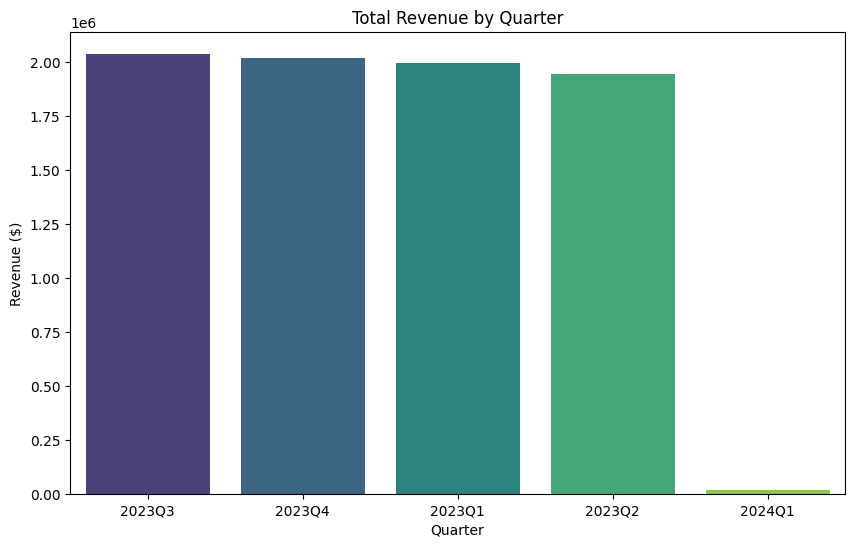

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'order_date' is datetime and 'quarter' is derived, as done in cell ehu7z41p2ynH
final_df["order_date"] = pd.to_datetime(final_df["order_date"])
final_df["quarter"] = final_df["order_date"].dt.to_period("Q")

# Calculate quarterly revenue and assign to quarterly_rev
quarterly_rev = final_df.groupby("quarter")["total_amount"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=quarterly_rev.index.astype(str), y=quarterly_rev.values, palette='viridis')
plt.title('Total Revenue by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Revenue ($)')
plt.show()